In [6]:
# importing libraries
import nltk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
#from BERT import bert_embed_text
import pandas as pd
import seaborn as sns
from matplotlib.pyplot import figure
from sklearn.metrics.pairwise import euclidean_distances
import transformers
import pandas as pd
from transformers import BertTokenizer

stop_words = set(nltk.corpus.stopwords.words('english'))
lemmatizer = WordNetLemmatizer() 

In [7]:
# loading the articles to embed
articles = pd.read_csv('../data/clean/"quantumcomputing"AND"research"_999.csv')
# remove rows with na as body
articles = articles.dropna(subset=['body'])

In [8]:
# apply split('\n\n') to all rows in body
articles['para'] = articles['body'].apply(lambda x: x.split('\n\n'))

# make df longer by exploding para
articles = articles.explode('para', ignore_index=False)
articles = articles.reset_index()

In [68]:
# apply sent_tokenize to all rows in para
from nltk.tokenize import sent_tokenize
articles['sent'] = articles['para'].apply(lambda x: sent_tokenize(x))

# average number of sentences per paragraph
articles['sent'].apply(lambda x: len(x)).mean()

1.678900158292783

In [19]:
# runs 10 minutes without GPU
from SBERT import bert_embed_words

articles['para_embed'] = articles['para'].apply(lambda x: bert_embed_words(x))

# articles.to_parquet('../data/misc/quant_embed_para.gzip',compression='gzip', index=False)

In [4]:
# Functions
# Cosine Similarity
def create_similarity_heatmap(corpus_embeddings):
    similarity_matrix = cosine_similarity(corpus_embeddings)
    sns.set(font_scale=1)
    
    # Use the figure method to set the DPI
    fig = figure(figsize=(11, 9), dpi=500) # Change the DPI as needed
    ax = fig.add_subplot()
    
    c = sns.heatmap(similarity_matrix, square=True,  ax=ax)
    c.set(xlabel='Document ID', ylabel='Document ID')
    plt.show()
    fig = c.get_figure()
    fig.suptitle('TF-IDF Document Similarity Matrix', fontsize=10)

def create_similarity_heatmap2(corpus_embeddings):
    similarity_matrix = cosine_similarity(corpus_embeddings)
    sns.set(font_scale=1)
    f, ax = plt.subplots(figsize=(11, 9))
    c = sns.heatmap(similarity_matrix, square=True,  ax=ax)
    c.set(xlabel='Document ID', ylabel='Document ID')
    plt.show()
    fig = c.get_figure()
    fig.suptitle('TF-IDF Document Similarity Matrix', fontsize=25)

# Elbow Method
def plot_elbow_method(embedding):
  
    Sum_of_squared_distances = []
    K = range(1,15)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(embedding)
        Sum_of_squared_distances.append(km.inertia_)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

# Kmeans
def get_cluster_kmeans(vectorize, num_clusters, r_state=100):
    km = KMeans(n_clusters = num_clusters, random_state=r_state )
    km.fit(vectorize)
    cluster_list = km.labels_.tolist()
    return cluster_list

# PCA
def pca_reduction(similarity_matrix, n_components):
    # calculate the one minus similarity matrix because PCA is a distance algorithm
    # thus, the more similar the documents, the closer they will be in the PCA space
    one_min_sim = 1 - similarity_matrix
    pca = PCA(n_components)
    pos = pca.fit_transform(one_min_sim)
    x_pos, y_pos = pos[:, 0], pos[:, 1]
    return (x_pos, y_pos)

# Cluster graph
def plot_graph(clusters, umap_data):
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = clusters
    plt.figure(figsize=(10,10))
    sns.scatterplot(
        x="x", y="y",
        hue="labels",
        palette='Spectral',
        data=result,
        legend="full"
    )

In [8]:
# UNUSED - Runs 30 minutes to embed bodies
# An alternative would be to try summarizing by paragraph
articles['body_embedding'] = None
for i in range(len(articles)):
    try:
        articles.at[i,'body_embedding'] = bert_embed_text(articles.at[i,'body']).tolist()
    except:
        articles.at[i,'body_embedding'] = []

# articles.to_parquet('../data/misc/quant_embed.gzip',compression='gzip', index=False)

In [5]:
# Load the embeddings, performing pca and clustering
bert_embed_text = pd.read_parquet('../data/misc/quant_embed_para.gzip')
sentence_embeddings_df = pd.DataFrame(bert_embed_text['body_embedding'].tolist(), index=bert_embed_text.index).dropna()
sentence_embeddings = np.array(sentence_embeddings_df)

# PCA (UMAP is apparently better in some cases)
n_pc = 10
one_min_sim = 1 - sentence_embeddings
pca = PCA(n_components=n_pc)
pos = pca.fit_transform(one_min_sim)

# Convert the result to a DataFrame
df = pd.DataFrame(pos, 
                  columns=[f'PC{i+1}' for i in range(n_pc)], 
                  index=sentence_embeddings_df.index)

#print('var explained: ', round(sum(pca.explained_variance_ratio_), 2))
#print(df.var(axis=0))
#df.boxplot()

# Kmeans (HDBSCAN is apparently better especially in combination with umap)
# Moreover we should consider removing outliers
n_clust = 4
km = KMeans(n_clusters=n_clust, random_state=3)
km.fit(df)
# works because articles with na body were dropped and extra care was taken to ensure that the index
# of the sentence_embeddings_df matches the index of the articles df
articles['cluster'] = km.labels_ 

In [ ]:
# Visualization for two clusters
# km_clusters_s_bert = km.labels_.tolist()
# plot_graph(km_clusters_s_bert, df)

# Mediod

In [7]:
# Getting the medoids of each cluster
assignments = km.predict(df)
closest_points = [None] * n_clust

for i in range(n_clust):
    points_in_cluster = df[assignments == i]
    distances = euclidean_distances(points_in_cluster, points_in_cluster)
    medoid_index = np.argmin(distances.sum(axis=0))
    closest_points[i] = points_in_cluster.index[medoid_index]

# add one hot encoded column to articles 1 if medoid 0 if not
articles['medoid'] = 0
# working version of prior line
for i in closest_points:
    articles.at[i,'medoid'] = 1

In [12]:
# loading the bert summarizer and tokenizer
nlp = transformers.pipeline("summarization")
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [13]:
def bart_summary(article):
    '''created a problem once potentially due to version (transformer version = 4.29.2)'''
    tokenized_input = tokenizer.tokenize(article)
    if len(tokenized_input) > 1023: # max input size for BART
        article = ' '.join(tokenized_input[:1000]).replace(' ##', '')

    summary = nlp(article) # set max size (! >30)
    if type(summary) == list:
        summary = summary[0]['summary_text']

    if type(summary) == dict:
        summary = summary['summary_text']
    return summary

from NER import extract_entities

for i in articles[articles['medoid'] == 1].index:
    clust = articles.at[i,'cluster']
    body = articles.at[i,'body']
    summary = bart_summary(body)
    orgs = extract_entities(articles[articles['cluster'] == clust], 3, 2, 10)
    orgs = ', '.join(orgs)
    print(f'Cluster {clust} \n Summary: {summary} \n Relevant orgs: {orgs} \n\n')


Cluster 0 
 Summary:  The global Quantum Computing for Enterprise market size will reach USD Million in 2029 , growing at a CAGR over the analysis period . The 121 pages report provides detailed cost analysis, supply chain . Technology innovation and advancement will further optimize the performance of the product , making it more widely used in downstream end users . Report provides valuable insights to players in the global market . 
 Relevant orgs: IBM, Google, Photonic Integrated Circuit, Microsoft, The MarketWatch News Department, North America, Global Topological, Comtex, MarketWatch Customer Service, Customer Center 


Cluster 2 
 Summary:  Moderna and IBM are joining forces to incorporate artificial intelligence and quantum computing into mRNA development . The agreement signed between the two companies is meant to “advance and accelerate mRNA research and science,” according to the companies’ announcement . IBM will allow Moderna to access its systems for quantum computing, wh

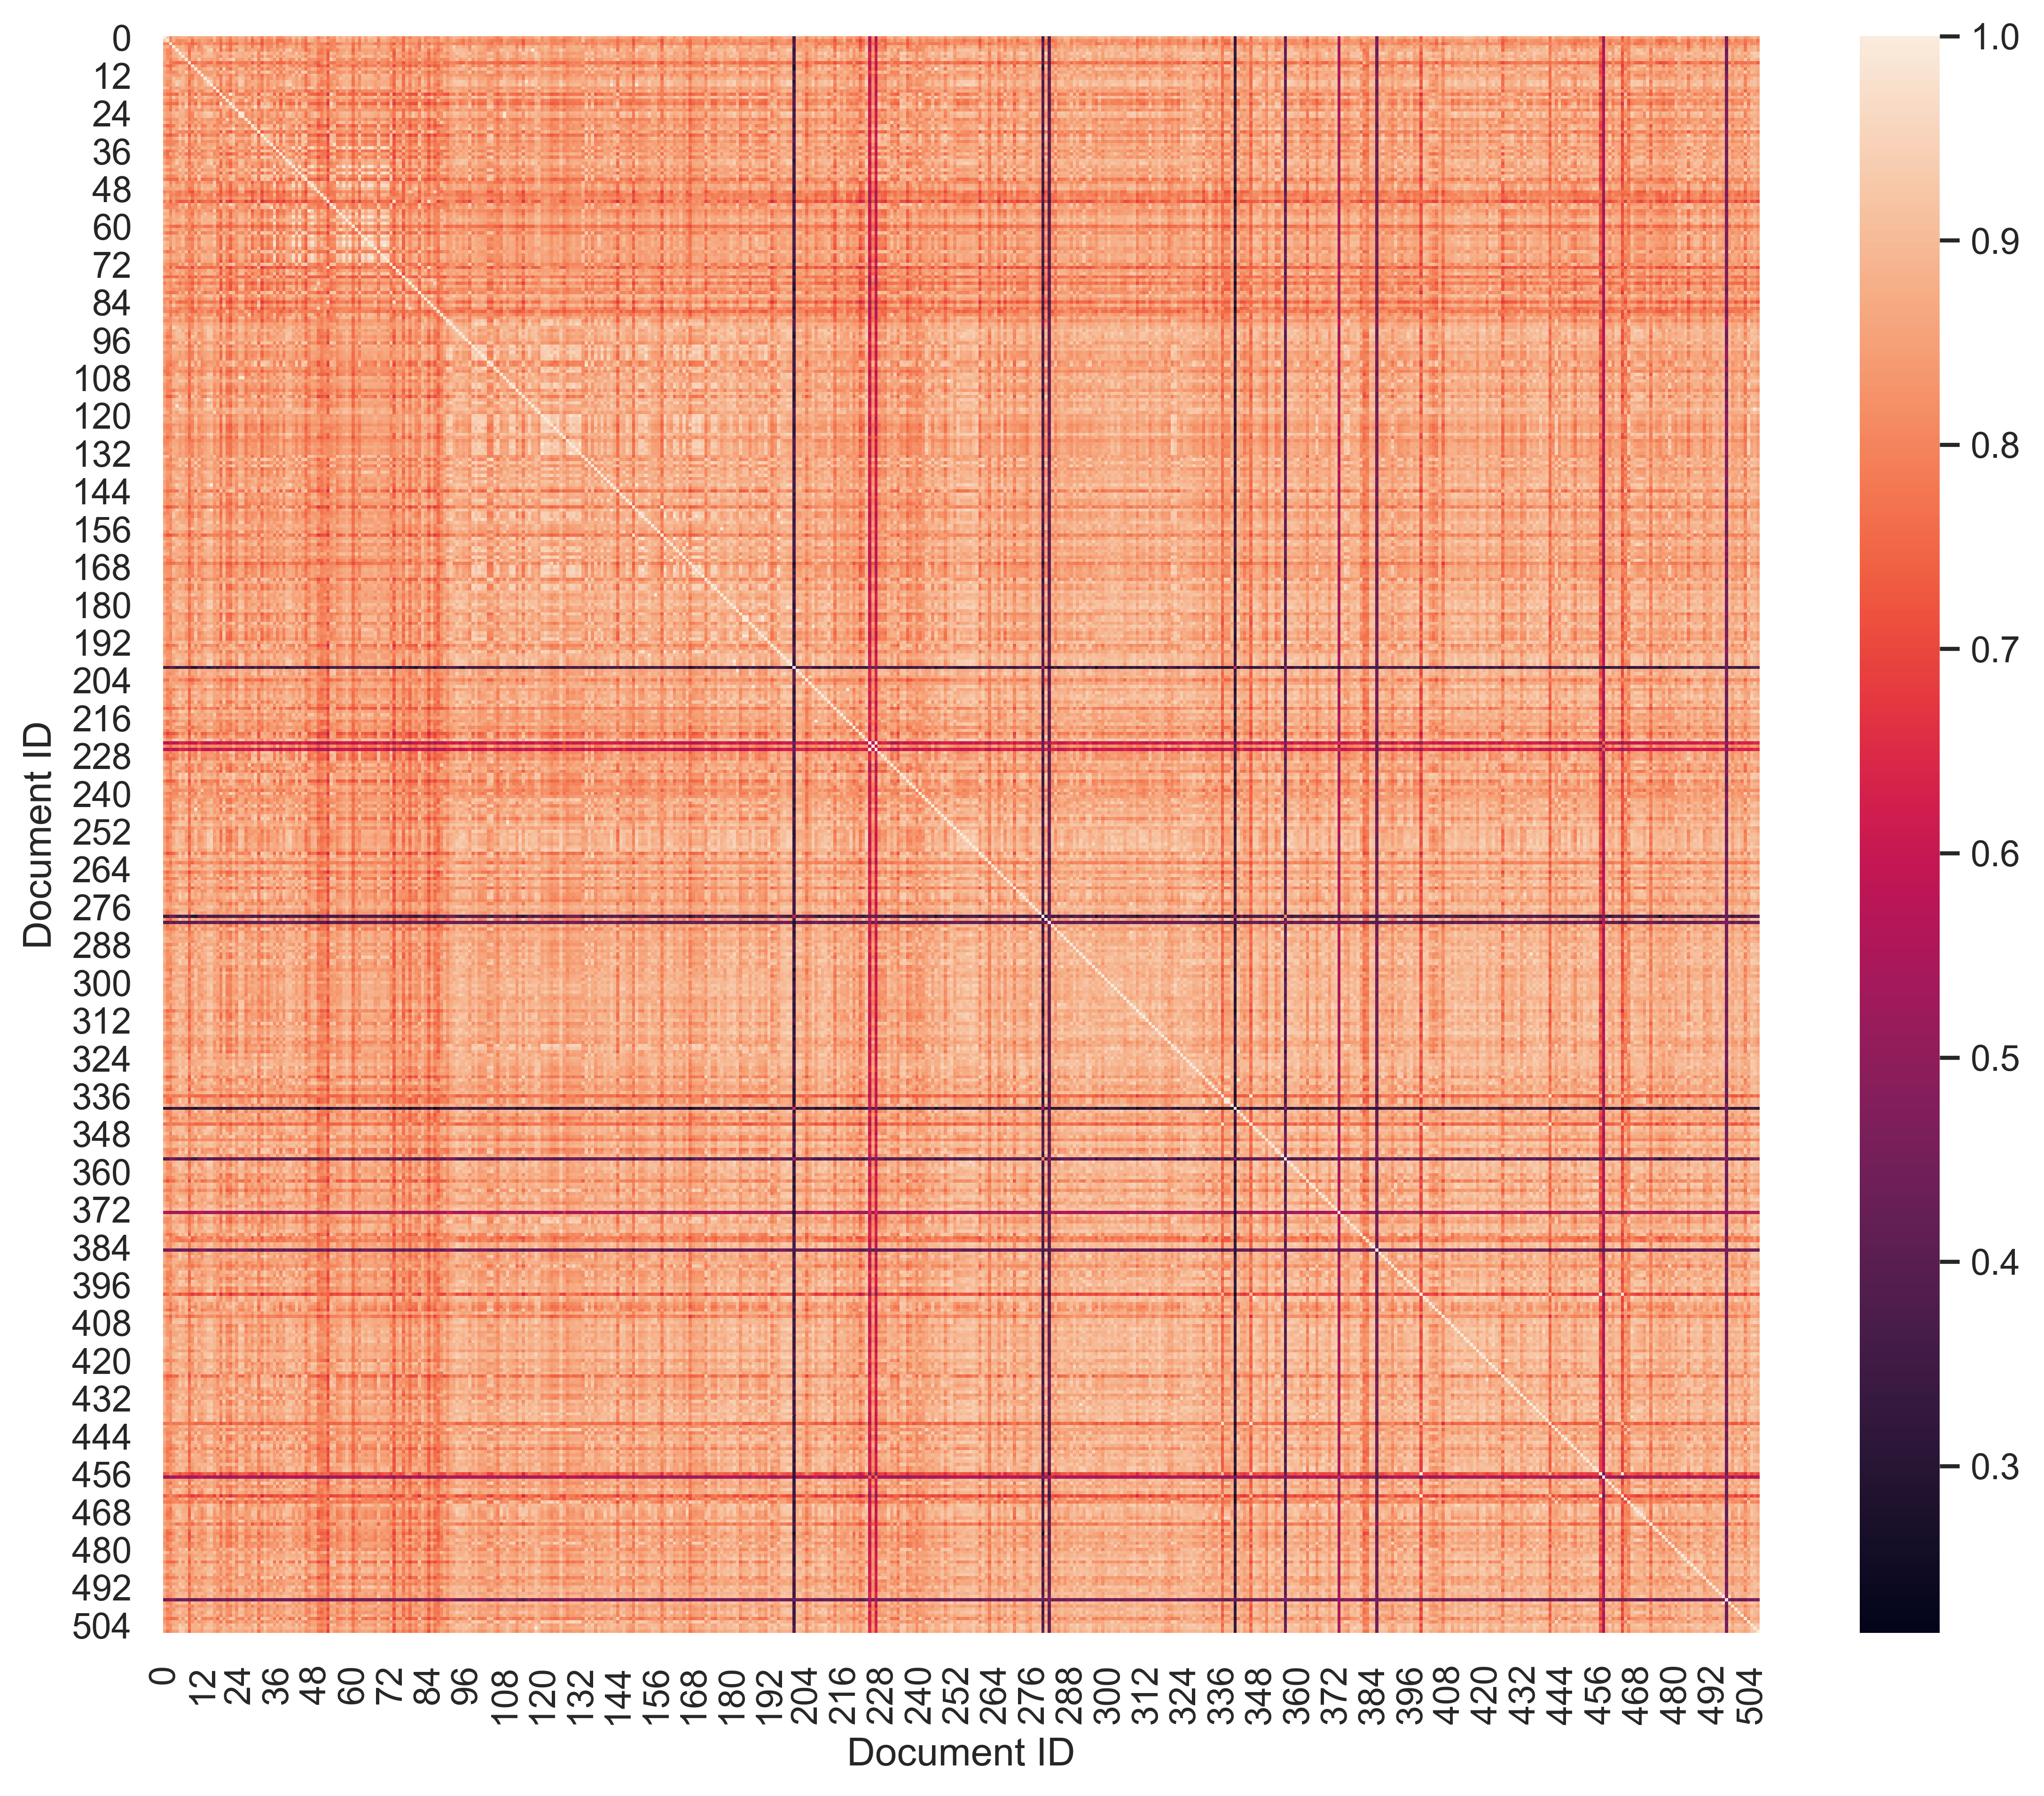

In [102]:
# Heatmap for similarity between articles
create_similarity_heatmap(sentence_embeddings)
# sentence_embeddings_df.mean(axis=1).sort_values(ascending=False).head(20)